# One-dimensional Packed-bed reactor model without streamwise diffusion

The present model simulates heterogeneous catalytic processes inside packed-bed, catalytic membrane reactors. The gas-phase and surface-phase species conservation equations are derived and the system of differential-algebraic equations (DAE) is solved using the scikits.odes.dae IDA solver.

In [1]:
# Import Cantera and scikits
from __future__ import print_function, division
import numpy as np
from scikits.odes import dae
from scikits.odes.sundials import ida
import cantera as ct
import matplotlib.pyplot as plt
%matplotlib inline
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.6.0a4


## Catalytic membrane reactors

## Methodology

One-dimensional, steady-state catalytic-membrane reactor code with surface chemistry is developed to analyze species profiles along the length of a packed-bed, catalytic membrane reactor. The same model can further be simplified to simulate a simple packed-bed reactor by excluding the membrane.

### Governing equations

Assuming steady, isothermal, one-dimensional flow within the packed bed, total-mass and species mass conservation may be stated as~\cite{KKZDK17}

\begin{equation} 
\label{eq:mass_continuity_onepass}
\frac{{\rm d}(\rho u)}{{\rm d}z} = \sum_{k=1}^{K_{\text{g}}} \dot s_k W_k A_{\text{s}} + \frac{P_{\rm b}}{A_{\rm b}} \sum_{k=1}^{k_{\text{g}}} j_{k, {\rm M}},
\end{equation}
\begin{equation} 
\label{eq:species_continuity_onepass}
\rho u \frac{{\rm d}Y_k}{{\rm d}z} + A_{\text{s}} Y_k \sum_{k=1}^{K_{\text{g}}} \dot s_k W_k  =  A_{\rm s} \dot s_k W_k +  \frac{P_{\rm b}}{A_{\rm b}} j_{k, {\rm M}}.
\end{equation}

The fractional coverages of the $K_{\rm s}$ surface adsorbates $\theta_k$ must satisfy 
\begin{equation}
    \dot s_k = 0,     {\ \ \ \ \ \ } (k = 1,\ldots, K_{\rm s}),
    \label{eq:sdotzero}
\end{equation}
which, at steady state, requires no net production/consumption of surface species by the heterogeneous reactions ([Kee et al.]~\cite{KCGZ18}.

The independent variable in these conservation equations is the position $z$ along the reactor length.  The dependent variables include the superficial velocity $u$, the gas-phase mass fractions $Y_k$, and the surfaces coverages $\theta_k$.  Gas-phase fluxes through the membrane are represented as $j_{k, {\rm M}}$. Geometric parameters $A_{\rm s}$, $P_{\rm b}$, and $A_{\rm b}$ represent the catalyst specific surface area (i.e., surface area per unit volume), reactor perimeter, and reactor cross-sectional flow area, respectively.  Other parameters include bed porosity $\phi_{\rm g}$ and gas-phase species molecular weights $W_k$. The gas density $\rho$ is evaluated using the equation of state (ideal Eos, RK or PR EoS).

The membrane flux is calculated using Sievert's law as
\begin{equation} \label{eq:membraneFlux}
j_{k_{\rm M}}^{\rm{Mem}} = \frac{B_{k_{\rm M}}}{t} \left ( p_{k_{\rm M}, {\rm{mem}}}^\alpha - p_{k_{\rm M}, {sweep}}^\alpha \right ) W_{k_{\rm M}}
\end{equation}
where $B_{k_{\rm M}}$ is the membrane permeability, $t$ is the membrane thickness. $p_{k_{\rm M}, {mem}}$ and $p_{k_{\rm M}, {sweep}}$ represent perm-selective species partial pressures within the packed-bed and the exterior sweep channel. The present model takes the pressure exponent $\alpha$ to be unity. The present model also assumes $p_{k_{\rm M}, {sweep}}=0$. The membrane flux for all other species ($ k \neq k_{\rm M}$) is zero.



### Define gas-phase and surface-phase species

In [2]:
# Import the reaction mechanism for Ammonia synthesis/decomposition on Ru-Ba/YSZ catalyst
mechfile = 'data/Ammonia-Ru-Ba-YSZ.yaml'
# Import the models for gas-phase
gas = ct.Solution(mechfile, 'gas');
# Import the model for surface-phase
surf = ct.Interface(mechfile, 'Ru_surface', [gas]);

# Other parameters
n_gas = gas.n_species               # number of gas species
n_surf = surf.n_species             # number of surface species
n_gas_reactions = gas.n_reactions   # Number of gas-phase reactions

# Set offsets
offset_rhou = 0
offset_p = 1
offset_T = 2
offset_Y = 3
#offset_Z = offset_Y + n_gas
#n_var = offset_Z + n_surf           # total number of variables (rhou, P, T, Yk and Zk)
n_var = 3 + n_gas
print("Number of variables = ", n_var)

Number of variables =  7


### Define reactor geometry and operating conditions

In [3]:
# Inlet operating conditions
T_in = 673                      # inlet temperature [K]             
p_in = 5e5                      # inlet pressure [Pa]
v_in = 0.01                     # inlet velocity [m/s]

gas.TPX = T_in, p_in, "NH3:1"
surf.TP = T_in, p_in
Yk_0 = gas.Y
rhou0 = gas.density * v_in

# Reactor geometry
L = 5e-2                        # length of the reactor
phi = 0.6                       # porosity of the bed
tau = 2.0                       # toruosity of the bed
dp = 3.37e-4                    # particle diameter
As = 1e8                        # specific surface area

# Initial surface coverages
surf.advance_coverages(1e10)    # Assuming the steady state is reached after 1000s.
#surf.solve_psuedo_steady_state_problem(1,1)
Zk_0 = surf.coverages

# Get required properties based on the geometry and mechanism
W_g = gas.molecular_weights                              # vector of molecular weight of gas species
vol_ratio = phi/(1-phi)
eff_factor = phi/tau                                     # effective factor for permeability calculation
B_g = pow(vol_ratio, 2) * pow(dp, 2) * eff_factor / 72;  # permeability based on Kozeny-Carman equation

### Define residual function

In [4]:
def residual(z, y, yPrime, res):
    """ Solution vector for the model
        y = [rho*u, p, T, Yk, Zk]
        yPrime = [d(rho*u)dz, dpdz, dTdz, dYkdz, dZkdz]
    """
    # Get current thermodynamic state from solution vector and save it to local variables.
    rhou = y[offset_rhou]               # mass flux (density * velocity)
    Y = y[offset_Y:offset_Y + n_gas]    # vector of mass fractions of all gas species
    #Z = y[offset_Z:offset_Z + n_surf]   # vector of site fractions of all surface species
    p = y[offset_p]                     # pressure
    T = y[offset_T]                     # temperature
    #print(y)
    
    drhoudz = yPrime[offset_rhou]           # mass-flux spatial derivative
    dYdz = yPrime[offset_Y:offset_Y+n_gas]  # mass fraction spatial derivative
    #dZdz = yPrime[offset_Z:offset_Z+n_surf] # site fraction spatial derivative
    dpdz = yPrime[offset_p]                 # pressure spatial derivative
    dTdz = yPrime[offset_T]                 # temperature spatial derivative
    
    # Set current thermodynamic state for the gas and surface phases
    # Note: use unnormalized mass fractions and site fractions to avoid over-constraining the system)
    gas.set_unnormalized_mass_fractions(Y)
    #gas.Y = Y
    gas.TP = T,p
    surf.TP = T,p
    #surf.set_unnormalized_coverages(Z)
    surf.advance_coverages(1e10)    # Assuming the steady state is reached after 1000s.
    
    # Calculate required variables based on the current state
    coverages = surf.coverages                   # Surface site coverages
    sdot_g = surf.net_production_rates[0:n_gas]             # heterogeneous production rate of gas species
    sdot_s = surf.net_production_rates[n_gas:n_gas+n_surf]  # heterogeneous production rate of surface species
    wdot_g = np.zeros(n_gas)
    if n_gas_reactions > 0:
        wdot_g = gas.net_production_rates        # homogeneous production rate of gas species
    mu = gas.viscosity                           # viscosity of the gas-phase
    
    # Conservation of total-mass 
    res[offset_rhou] = drhoudz - (As*np.sum(sdot_g*W_g) + phi*np.sum(wdot_g*W_g))
    sum_continuity = As*np.sum(sdot_g*W_g)       # temporary variable
    #print(sdot_s)

    # Conservation of gas-phase species
    for k in range(n_gas):
        res[offset_Y+k] = dYdz[k] + (Y[k]*sum_continuity
                       - phi*wdot_g[k]*W_g[k] - As*sdot_g[k]*W_g[k])/rhou
        #print("k", k, "y = ", Y[k], "res = ", res[offset_Y+k])
        
    # Conservation of site fractions (algebraic contraints in this example)
    #for k in range(n_surf):
    #    res[offset_Z+k] = sdot_s[k]
        
    # For the species with largest site coverage, use the constraint sum(Zk) = 1
    #ind_large = np.argmax(coverages)
    #res[offset_Y+ind_large] = 1 - np.sum(coverages)
    
    # Conservation of momentum
    u = rhou/gas.density
    res[offset_p] = dpdz + phi*mu*u/B_g
    #print(dpdz, res[offset_p])
    
    # Conservation of energy
    res[offset_T] = dTdz - 0
    
    # Calculate density using equation of state
    # rho = gas.density
    
    #print("y = ", y)
    #print("res = ", res)

### Set consistent initial conditions

In [5]:
# Initialize yPrime to 0 
#y0 = np.hstack((rhou0, p_in, T_in, Yk_0, Zk_0))
y0 = np.hstack((rhou0, p_in, T_in, Yk_0))
yprime0 = np.hstack(np.zeros(n_var))
res = np.hstack(np.zeros(n_var))
residual(0, y0, yprime0, res)
for n in range(n_var):
    yprime0[n] = -res[n]

### Solve the system of DAEs using ida solver

In [11]:
tempArray = np.ones(n_var)
#tempArray2 = np.ones(n_var, dtype=int)

solver = dae(
    'ida',
    residual, 
    #compute_initcond='yp0',
    first_step_size=1e-15,
    atol=1e-08,  # absolute tolerance for solution
    rtol=1e-06,  # relative tolerance for solution
    #algebraic_vars_idx=[np.arange(offset_Y+n_gas,offset_Z+n_surf,1)], 
    max_steps=8000,
    max_step_size = 1e-03,
    max_conv_fails = 50,
    max_nonlin_iters = 20,
    #constraints_idx = tempArray,
    constraints_type = tempArray,
    #order = 5,
    #enforce_nonnegativity = True,
    one_step_compute=True,
    #exclude_algvar_from_error = True,
    old_api=False  # Forces use of new api (namedtuple)
)

#times = np.arange(0,L,1e-3)
#solution = solver.solve(times, y0, yprime0)
time = []
solution = []
state = solver.init_step(0.0, y0, yprime0)
#print(state)
#print(state.values.y)
while state.values.t < L :
    time.append(state.values.t)
    solution.append(state.values.y)
    #print(state.values.t)
    state = solver.step(L)
    #print(state)
    
time = np.array(time)
solution = np.array(solution)
#print(solution)

### Plot results

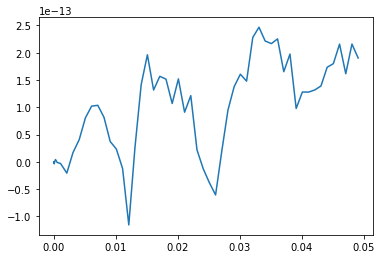

In [12]:
pSteady = solution[:,offset_Y + 0]
plt.plot(time, pSteady)

IndexError: too many indices for array

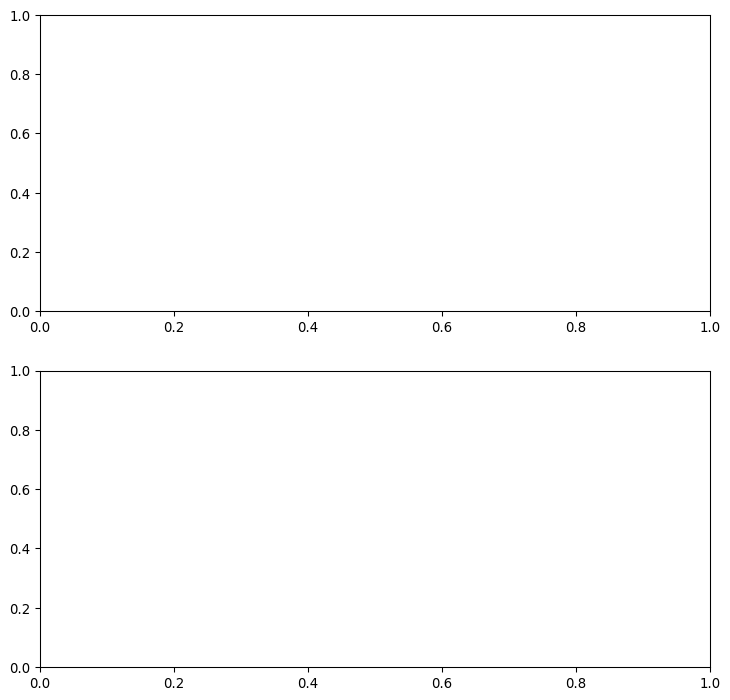

In [8]:
# plot pressure of gas along the reactor length
f, ax = plt.subplots(2,1, figsize=(9,9), dpi=96)
ax[0,0].plot(time, solution[:, offset_p], color='C0')
ax[0,0].set_xlabel('Distance (m)')
ax[0,0].set_ylabel('Pressure (Pa))')

# plot temperature of gas along the reactor length
ax[0,1].plot(time, solution[:,offset_T], color='C1')
ax[0,1].set_xlabel('Distance (m)')
ax[0,1].set_ylabel('Temperature (K))')
ax[0,1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))  # scientific notation


In [ ]:
# plot pressure of gas along the reactor length
f, ax = plt.subplots(3,2, figsize=(9,9), dpi=96)
ax[0,0].plot(times, solution.values.y[:,1], color='C0')
ax[0,0].set_xlabel('Distance (m)')
ax[0,0].set_ylabel('Pressure (Pa))')

# plot temperature of gas along the reactor length
f, ax = plt.subplots(3,2, figsize=(9,9), dpi=96)
ax[0,0].plot(times, solution.values.y[:,2], color='C0')
ax[0,0].set_xlabel('Distance (m)')
ax[0,0].set_ylabel('Temperature (K))')

# plot gas-phase species mole fractions

# plot minor species
for i in minor_idx:
    style = '-' if i < 10 else '--'    
    ax[1,0].plot(times, solution.values.y[:,2+i], label=gas.species_names[i], linestyle=style)
ax[1,0].legend(fontsize=7, loc='upper right')
ax[1,0].set_xlabel('Distance (m)')
ax[1,0].set_ylabel('Mass Fraction')
ax[1,0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))  # scientific notation

# plot major species
for j in major_idx:
    ax[1,1].plot(times,solution.values.y[:,2+j], label=gas.species_names[j])
ax[1,1].legend(loc='best')
ax[1,1].set_xlabel('Distance (m)')
ax[1,1].set_ylabel('Mass Fraction')

# plot the pressure of the gas along the flow direction
ax[2,0].plot(times, solution.values.y[:,2+N], color='C2')
ax[2,0].set_xlabel('Distance (m)')
ax[2,0].set_ylabel('Pressure (Pa)')

# plot the site fraction of the surface species along the flow direction 
for i,name in enumerate(gas_Si_N_interface.species_names):
    ax[2,1].plot(times, solution.values.y[:,3+N+i], label=name)
ax[2,1].legend()
ax[2,1].set_xlabel('Distance (m)')
ax[2,1].set_ylabel('Site Fraction')
f.tight_layout(pad=0.5)